In [2]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import json
import os
import random
import sys
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch
import time
import torch.nn as nn
from collections import defaultdict
from scipy.interpolate import make_interp_spline
from memory_profiler import memory_usage
from pynvml import *
import threading
import time


In [3]:
agents = [2,4,8]
goals = [0,1,5,10]
MAPF = "CBS"
SAPF = "TDSP"
costFunction = "SIC"
heuristic = ""


def drawGraph(G):
    labeldict = {}
    for node in G.nodes:
        labeldict[node] = G.nodes[node]["name"]

    plt.figure(figsize=(4096/90, 2160/90))
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, nx.get_node_attributes(G, 'pos'), edge_labels=labels)
    nx.draw(G, nx.get_node_attributes(G, 'pos'), labels = labeldict, with_labels=True, node_size = 100, font_size = 3)
    plt.show()


def saveGraphImage(filename, G):
    labeldict = {}
    for node in G.nodes:
        labeldict[node] = G.nodes[node]["name"]

    labels = nx.get_edge_attributes(G,'weight')
    plt.figure(figsize=(4096/90, 2160/90))
    nx.draw_networkx_edge_labels(G,nx.get_node_attributes(G, 'pos'),edge_labels=labels)
    nx.draw(G, nx.get_node_attributes(G, 'pos'), labels = labeldict, with_labels=True, node_size = 10000, font_size = 20)
    plt.savefig(filename+".pdf", dpi = 1200, orientation = "landscape", transparent = False)
    # plt.savefig(filename+".png", dpi = 1200, orientation = "landscape", transparent = False)


def getGraphFromJson(filename = "graph.json"):
    G = nx.DiGraph()
    with open (filename, "r") as fileJson:
        data = json.load(fileJson)
        for v in data["nodes"]:
            G.add_node(v[1], pos=(v[2], v[3]), name=v[0])

        for row in range(len(data["connect"])):
            for col in range(len(data["connect"][row])):
                if data["connect"][row][col] == 1:
                    G.add_edge(row, col, weight=data["connect"][row][col])

    if filename == "graph.json":
        G.add_edge(135, 144, weight=1)
        G.add_edge(143, 145, weight=1)
        G.add_edge(161, 162, weight=1)
        G.add_edge(173, 174, weight=1)
        G.add_edge(185, 186, weight=1)
        G.add_edge(144, 135, weight=1)
        G.add_edge(145, 143, weight=1)
        G.add_edge(162, 161, weight=1)
        G.add_edge(174, 173, weight=1)
        G.add_edge(186, 185, weight=1)

    # drawGraph(G)
    return G


def extractBuilding1(G : nx.DiGraph):
    if not os.path.isdir("maps/build1"):
        os.mkdir("maps/build1")

    build = nx.DiGraph()
    nodeMap = {}
    for node in G.nodes:
        if G.nodes[node]["pos"][0] < 74:
            build.add_node(len(build.nodes), pos=G.nodes[node]["pos"], name=G.nodes[node]["name"])
            nodeMap[node] = len(build.nodes) - 1

    for edge in G.edges:
        if edge[0] in nodeMap and edge[1] in nodeMap:
            if nodeMap[edge[0]] in build.nodes and nodeMap[edge[1]] in build.nodes:
                build.add_edge(nodeMap[edge[0]], nodeMap[edge[1]], weight=G.edges[edge]["weight"])

    saveGraphImage("maps/build1/build1", build)
    if nx.is_strongly_connected(build):
        print("Build1 connected")
    else:
        print("Build 1 not connected")

    return build


def extractBuilding2(G : nx.DiGraph):
    if not os.path.isdir("maps/build2"):
        os.mkdir("maps/build2")
    build = nx.DiGraph()
    nodeMap = {}
    for node in G.nodes:
        if G.nodes[node]["pos"][0] > 109:
            build.add_node(len(build.nodes), pos=G.nodes[node]["pos"], name=G.nodes[node]["name"])
            nodeMap[node] = len(build.nodes) - 1

    for edge in G.edges:
        if edge[0] in nodeMap and edge[1] in nodeMap:
            if nodeMap[edge[0]] in build.nodes and nodeMap[edge[1]] in build.nodes:
                build.add_edge(nodeMap[edge[0]], nodeMap[edge[1]], weight=G.edges[edge]["weight"])

    saveGraphImage("maps/build2/build2", build)
    if nx.is_strongly_connected(build):
        print("Build 2 connected")
    else:
        print("Build 2 not connected")

    return build



def extractBridge(G : nx.DiGraph):
    if not os.path.isdir("maps/bridge"):
        os.mkdir("maps/bridge")
    build = nx.DiGraph()
    nodeMap = {}
    for node in G.nodes:
        if G.nodes[node]["pos"][0] < 109 and G.nodes[node]["pos"][0] > 73:
            build.add_node(len(build.nodes), pos=G.nodes[node]["pos"], name=G.nodes[node]["name"])
            nodeMap[node] = len(build.nodes) - 1

    for edge in G.edges:
        if edge[0] in nodeMap and edge[1] in nodeMap:
            if nodeMap[edge[0]] in build.nodes and nodeMap[edge[1]] in build.nodes:
                build.add_edge(nodeMap[edge[0]], nodeMap[edge[1]], weight=G.edges[edge]["weight"])

    saveGraphImage("maps/bridge/bridge", build)
    if nx.is_strongly_connected(build):
        print("Bridge connected")
    else:
        print("Bridge not connected")

    return build


def createRandom(G : nx.DiGraph, outputDir : str):
    if not os.path.isdir(outputDir):
        os.mkdir(outputDir)

    data = dict()
    data["MAPF"] = MAPF
    data["SAPF"] = SAPF
    data["costFunction"] = costFunction
    data["heuristic"] = heuristic
    data["nNodes"] = len(G.nodes)
    data["nodes"] = []
    for node in G.nodes:
        data["nodes"].append((G.nodes[node]["name"], G.nodes[node]["pos"][0], G.nodes[node]["pos"][1], node))
    data["connect"] = nx.adjacency_matrix(G, nodelist=sorted(G.nodes)).todense().tolist()

    counter = 0

    for nAgents in agents:
        if nAgents >= len(data["nodes"]):
            print("Skipping nAgents = " + str(nAgents) + " because it is too big")
            continue
        data["nAgents"] = nAgents
        data["agents"] = [{} for a in range(nAgents)]
        initPos = random.sample(list(data["nodes"]), nAgents)
        endPos = []
        if nAgents > 50 * len(data["nodes"]) / 100.0:
            endPos = initPos
        else:
            endPos = random.sample([n for n in data["nodes"] if n not in initPos], nAgents)

        for a in range(nAgents):
            data["agents"][a]["ID"] = a
            data["agents"][a]["initPos"] = initPos[a]
            data["agents"][a]["endPos"] = endPos[a]

        for nGoals in goals:
            nonEndPos = [n for n in data["nodes"] if n not in endPos]
            for a in range(nAgents):
                data["agents"][a]["goalPos"] = []
                if nGoals > 0:
                    data["agents"][a]["goalPos"].append(random.choice(nonEndPos))
                for i in range(1, nGoals):
                    tmp = random.choice(nonEndPos)
                    while tmp == data["agents"][a]["goalPos"][-1]:
                        tmp = random.choice(nonEndPos)
                    data["agents"][a]["goalPos"].append(tmp)

            # Make sure that no goalPos is also an endPos
            for a in range(nAgents):
                for n in data["agents"][a]["goalPos"]:
                    if n in endPos:
                        raise Exception("goalPos is already an endPos")

            with open("temp.json", "w+") as output:
                json.dump(data, output, indent = 2)

            with open("temp.json", "r") as temp:
                with open(os.path.join(outputDir, str(counter)+".json"), "w+") as output:
                    for line in temp:
                        if any(x in line for x in ["{" , "}", "nNodes", "nodes", "connect", "]", "MAPF", "SAPF", "costFunction", "heuristic", "nAgents", "ID", "goalPos"]):
                            output.write(line)
                        else:
                            line = line.split("\n")[0]
                            output.write(line)

            os.remove("temp.json")

            counter += 1
            print(counter, end="\r")


if __name__ == "__main__":
    random.seed(1)  # for repeatability
    if not os.path.isdir("maps"):
        os.mkdir("maps")
    if not os.path.isdir("maps/uni"):
        os.mkdir("maps/uni")


In [4]:
class Agent:
    def __init__(self, data,num_nodes,shortest_path_lengths,map):
        self.id = data["ID"]
        if map == "uni":
            self.init_pos = data["initPos"][0]
            self.end_pos = data["endPos"][0]
            self.goal_pos = data["goalPos"][0] if len(data["goalPos"])>0 else None
        else:
            self.init_pos = data["initPos"][1]
            self.end_pos = data["endPos"][1]
            self.goal_pos = data["goalPos"][0] if len(data["goalPos"])>0 else None
        self.num_nodes=num_nodes
        self.current_pos = self.init_pos
        self.window_size=10
        self.path = [self.init_pos]
        self.shortest_path_lengths = shortest_path_lengths
    def __str__(self):
        return f"Agent(id={self.id}, init_pos={self.init_pos}, end_pos={self.end_pos}, goal_pos={self.goal_pos})"
    def get_id(self):
        return self.id
    def get_init_pos(self):
        return self.init_pos
    def get_end_pos(self):
        return self.end_pos
    def get_current_pos(self):
        return self.current_pos
    def get_enc_end_pos(self):
        encoded_end_pos=np.zeros(self.num_nodes)
        encoded_end_pos[self.end_pos]=1
        return encoded_end_pos
    def get_enc_current_pos(self):
        encoded_current_pos=np.zeros(self.num_nodes)
        encoded_current_pos[self.current_pos]=1
        return encoded_current_pos
    
    def get_prev_path(self):
        return self.path
    def get_goal_pos(self):
        return self.goal_pos
    def update_path(self, new_node):
        self.path.append(new_node)
        self.current_pos = new_node

    def get_collision(self, agent_list):
        collision = []
        for agent in agent_list:
            if agent.get_id() != self.get_id():
                if agent.get_current_pos() == self.get_current_pos():
                    collision.append(agent.get_id())
        
        return 1 if len(collision)>0 else 0

    def get_distance_towards_agents(self, agent_list):
        distance = []
        for agent in agent_list:
                distance.append(self.shortest_path_lengths[self.get_current_pos()][agent.get_current_pos()])
        return distance
    def get_occupancy(self, graph,agent_list):
        graph_nodes=np.zeros(self.num_nodes)
        for agent in agent_list:
            graph_nodes[agent.get_current_pos()]=1
        return graph_nodes

    def get_features(self, graph, agent_list):
        '''
        returns features for agent in the following order:
        1. one hot encoding of current position
        2. one hot encoding of end position
        3. past movement of agent
        4. collision with other agents
        5. distance towards other agents
        6. blocked nodes
        '''
        features= np.hstack((self.get_enc_current_pos(), self.get_enc_end_pos(), self.get_prev_path(), [self.get_collision( agent_list)], 
                             self.get_distance_towards_agents(agent_list), self.get_occupancy(graph, agent_list)))
        return torch.tensor(features).float()
    

    
    def generate_node_features(self, num_nodes, adjacency_matrix, agent_list,G, path_decay=0.9):
        """
        Creates input feature vector for a given agent.
        Includes path memory and distance to other agents.
        """
        features = torch.zeros((num_nodes, 7))
        agent_positions = set(a.get_current_pos() for a in agent_list) 
        current_node = self.get_current_pos()
        goal_node = self.get_end_pos()
        prev_path = self.get_prev_path()

        features[:, 0] = torch.tensor([1 if i == current_node else 0 for i in range(num_nodes)])
        features[:, 1] = torch.tensor([1 if i == goal_node else 0 for i in range(num_nodes)])
        features[:, 2] = torch.tensor([self.shortest_path_lengths[i][goal_node] / num_nodes for i in range(num_nodes)])
        features[:, 3] = torch.tensor([path_decay ** prev_path.count(i) if i in prev_path else 0 for i in range(num_nodes)])
        features[:, 4] = torch.tensor([1 if i in agent_positions else 0 for i in range(num_nodes)])
        return features



    def __repr__(self):
        return f"Agent(id={self.id}, init_pos={self.init_pos}, end_pos={self.end_pos}, goal_pos={self.goal_pos})"

In [5]:
class HebbianLinear(nn.Module):
    def __init__(self, in_features, out_features, lr=0.01,adj_matrix=None,A=0.1,B=0.1,C=0.01,D=0.01):
        super().__init__()
        self.adj_matrix=adj_matrix.to("cuda" if torch.cuda.is_available() else "cpu")
        self.weight = nn.Parameter(torch.rand(in_features, out_features).to("cuda" if torch.cuda.is_available() else "cpu") *self.adj_matrix, requires_grad=False)
        self.lr = lr
        self.A=A
        self.B=B
        self.C=C
        self.D=D
    def forward(self, x):
        self.last_input = x.detach()  
        out = F.linear(x, self.weight)
        self.last_output = out.detach()
        return out

    def hebbian_update(self,reward):
        # Apply basic Hebbian rule
        pre = self.A*self.last_input
        post = self.B*self.last_output
        C_part = self.C*pre*post
        dw= pre + post + C_part + self.D
        
        oja_decay = self.lr * (post ** 2) * self.weight.data
        dw = dw - oja_decay
        self.weight.data += (np.sign(reward))*self.lr*(dw*self.adj_matrix) #- decay_param* self.weight.data

class HebbianGCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, lr=0.01,adj_matrix=None,A=0.1,B=0.1,C=0.01,D=0.0001):
        super().__init__()
        self.adj_matrix = adj_matrix.to("cuda" if torch.cuda.is_available() else "cpu")
        self.linear = HebbianLinear(in_channels, out_channels, lr,self.adj_matrix, A, B, C, D)
        self.lr = lr
        self.A=A
        self.B=B
        self.C=C
        self.D=D
        self.aggregation_weight = nn.Parameter(torch.ones(in_channels, out_channels).to("cuda" if torch.cuda.is_available() else "cpu") *0.01*self.adj_matrix, requires_grad=False)
    def forward(self, x, edge_index):
        # Basic GCN-style aggregation (mean over neighbors)
        row, col = edge_index
        weighted_x = x * self.aggregation_weight
        deg = torch.bincount(row, minlength=x.size(0)).clamp(min=1).float().unsqueeze(1)
        agg = torch.zeros_like(x)
        agg.index_add_(0, row, weighted_x[col])
        agg = agg / deg
        return self.linear(agg)

    def hebbian_update(self,reward,current_node,next_node):
        if reward<0.0:
            pre = self.A*self.linear.last_input
            post = self.B*self.linear.last_output
            C_part = self.C*pre*post
            dw= pre + post + C_part + self.D
            oja_decay =  (post ** 2) * self.aggregation_weight.data
            dw = dw - oja_decay
            self.aggregation_weight.data[next_node,current_node] +=reward*dw[next_node,current_node]
 


class HebbianMLP(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels, eta=0.1,adj_matrix=None,A=0.1,B=0.1,C=0.01,D=0.01):
        super().__init__()
        self.A= A
        self.B= B
        self.C= C
        self.D= D
        self.eta=eta
        self.adj_matrix = adj_matrix.to("cuda" if torch.cuda.is_available() else "cpu")
        self.mlp = nn.Sequential(
            HebbianLinear(hidden_dim, out_channels, eta,adj_matrix,A,B,C,D), 
        
        )

        

    def forward(self, x):

        x = self.mlp(x)
        return x 
    def hebbian_update(self, reward, chosen_action_idx,next_node):

        last_layer = self.mlp[0]
        pre_val = last_layer.last_input.detach()[chosen_action_idx]  # Typically 1 for the current state.
        post_val = last_layer.last_output.detach()[next_node]
        hebb_term = self.A * pre_val + self.B * post_val + self.C * (pre_val * post_val) + self.D
        decay_parameter=0.1

        oja_decay = (post_val ** 2) * last_layer.weight.data[next_node, chosen_action_idx]
        
        delta = reward * (hebb_term - decay_parameter*oja_decay)
 
        last_layer.weight.data[next_node, chosen_action_idx] += delta



class HebbianGNN(nn.Module):
    def __init__(self, in_channels, hidden_dim, eta,adj_matrix, A=0.1, B=0.1, C=0.01, D=0.01):
        super().__init__()
        self.node_embed = nn.Linear(in_channels, hidden_dim)
        self.layer1 = HebbianGCNLayer(hidden_dim, hidden_dim, eta,adj_matrix, A, B, C, D)
        self.layer2 = HebbianGCNLayer(hidden_dim, hidden_dim, eta,adj_matrix, A, B, C, D)
        self.mlp = HebbianMLP(hidden_dim, hidden_dim, hidden_dim, eta,adj_matrix, A, B, C, D)

        self.A=A
        self.B=B
        self.C=C
        self.D=D
    def forward(self, x, edge_index,current_node):

        x_embed = F.tanh(self.node_embed(x))
        pre_x1=self.layer1(x_embed, edge_index)
        x1 = F.tanh(pre_x1)
        x1 = F.dropout(x1, p=0.7)

        self.layer1.linear.last_input = x_embed
        self.layer1.linear.last_output = x1
        pre_x2=self.layer2(x1, edge_index)
        x2 =  F.tanh(pre_x2)
        x2 = F.dropout(x2, p=0.5)

        out= self.mlp(x2[current_node])
  
        return out

    def update_weights(self,reward,current_node,next_node):

        self.layer1.hebbian_update(reward,current_node,next_node)
        self.layer2.hebbian_update(reward,current_node,next_node)
        self.mlp.hebbian_update(reward,current_node,next_node)
       

In [74]:
def euclidean_weight(dist):
    """Compute weight from distance using inverse weighting."""
    return 1.0 / (dist + 0.1)

def get_valid_neighbors(agent, graph, excluded_nodes):
    """
    Returns a list of neighboring nodes (as per the graph)
    that are valid for deviation.
    Excluded nodes is a list of nodes that should not be selected.
    """
    current_pos = agent.get_current_pos()
    neighbors = list(graph.neighbors(current_pos))
    valid_neighbors = [n for n in neighbors if n not in excluded_nodes]
    return valid_neighbors

def weighted_random_choice(candidates, agent_goal, shortest_path_lengths):
    """
    Given candidate nodes, use the shortest path length from each candidate to the agent's goal 
    as a basis to compute weight (closer nodes get higher weight).
    """
    weights = []
    for candidate in candidates:

        d = shortest_path_lengths[candidate][agent_goal]
        weights.append(euclidean_weight(d))
    total_weight = sum(weights)
    probabilities = [w/total_weight for w in weights]
    chosen = random.choices(candidates, probabilities)[0]
    return chosen


def train_hebbian(model, agents, graph,num_nodes,epochs=100):
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(graph))
    device='cuda' if torch.cuda.is_available() else 'cpu'
    
    adj_matrix=nx.adjacency_matrix(graph).todense()
    adj_logits_matrix=torch.torch.tensor(adj_matrix).float().to(device)    
    
    for epoch in tqdm(range(epochs)):

        device='cuda' if torch.cuda.is_available() else 'cpu'
        model.to(device)
        model.train()
        
        edge_index = torch.tensor(np.array(list(graph.edges)).T, dtype=torch.long).to(device)  # Convert to edge index format
        reward=np.ones(len(agents))
        while not all(agent.get_current_pos() == agent.get_end_pos() for agent in agents):
            with torch.no_grad():
                collision_flags = np.zeros(len(agents), dtype=bool)
                collision = np.zeros(len(agents), dtype=bool)
                excluded_nodes=[]
                for i,agent in enumerate(agents):
                    step=False
                    state = agent.generate_node_features(num_nodes,adj_matrix,agents,graph).to(device)  # Extract node features
                    while not step:
                        out=model(state,edge_index,agent.get_current_pos())

                        
                        mask = adj_logits_matrix[agent.get_current_pos()].bool()
                        if collision_flags[i]:
                            mask[excluded_nodes] = False

                        masked_probs = torch.where(mask, out, torch.tensor(-float('inf')))
                        next_node=torch.argmax(masked_probs).item()

                        success = agent.get_current_pos() == agent.get_end_pos()
                        
                        if success:
                            step=True
                            continue
                        
                        for a in range(len(agents)):
                                if success:
                                    continue
                                if a != i:

                                    collision[i] = collision[i] or \
                                        (next_node == agents[a].get_current_pos())
                                    if next_node == agents[a].get_current_pos():
                                        excluded_nodes.append(agents[a].get_current_pos())
                        
                        if next_node == agent.get_end_pos():

                            reward[i] = 1.0
                            agent.update_path(next_node)
                            step=True

                        elif any(collision):
                            if success:
                                continue
                            if collision[i] and not collision_flags[i]:
            
                                candidates = get_valid_neighbors(agent, graph, excluded_nodes)
                                
                                if candidates:
                                    alternative_move = weighted_random_choice(candidates, agent.get_end_pos(), shortest_path_lengths)
                                    next_node = torch.tensor(alternative_move).to(device)

                                    excluded_nodes.append(alternative_move)
                                    agent.update_path(alternative_move)

                                    step = True
                                else:
                            
                                    next_node = torch.tensor(agent.get_current_pos()).to(device)

                                collision_flags[i] = True
                                collision[i]=False
                                    
                        else:
                            
                            prev_dist=shortest_path_lengths[agent.get_current_pos()][agent.get_end_pos()]
                            curr_dist=shortest_path_lengths[next_node][agent.get_end_pos()]
                            if curr_dist < prev_dist:
                                reward[i] = 0.7
                                
                                agent.update_path(next_node)
                                step=True
                                collision_flags[i] = False

                            elif agent.get_current_pos() == next_node and curr_dist == prev_dist:
                                    
                                    reward[i] =-0.3
                                  
                            else:
                                    reward[i] = -0.5
                                    
                        model.update_weights(reward[i],agent.get_current_pos(),next_node)
    for agent in agents:
        print(agent.get_id(), agent.get_prev_path())
                  

def connect_graph(G):
    components = list(nx.strongly_connected_components(G))
    representatives = [list(comp)[0] for comp in components]
    for i in range(len(representatives) - 1):
        G.add_edge(representatives[i], representatives[i + 1])
    return G

def remove_random_edges_while_connected(graph, num_edges_to_remove):
    """
    Removes a specified number of edges randomly from the graph while ensuring it remains strongly connected.
    """
    edges = list(graph.edges)
    random.shuffle(edges) 
    removed_edges = 0

    for edge in edges:
        graph.remove_edge(*edge)
        if not nx.is_strongly_connected(graph):
            graph.add_edge(*edge)
        else:
            removed_edges += 1
        if removed_edges == num_edges_to_remove:
            break

    return graph

def main_function(filename,G,map_name):
    with open(filename, "r") as file:
        data = json.load(file)
    if not nx.is_strongly_connected(G):
        print("Graph is not strongly connected. Adding edges to make it strongly connected.")
        G=connect_graph(G)
    
    agents = data.get("agents", [])
    num_nodes=data.get("nNodes")
    agent_list = []
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
    
    for agent in agents:
        agent_list.append(Agent(agent,num_nodes,shortest_path_lengths,map_name))
    for agent in agent_list:
        print(nx.shortest_path(G, agent.get_current_pos(), agent.get_end_pos(), weight='weight'))


    num_nodes = num_nodes
    input_dim = 7 
    hidden_dim = num_nodes  

    adj_matrix = nx.adjacency_matrix(G).todense()
    adj_matrix = torch.tensor(adj_matrix).float()
    adj_matrix = adj_matrix.to("cuda" if torch.cuda.is_available() else "cpu")
    model = HebbianGNN(input_dim, hidden_dim, eta=0.1,adj_matrix=adj_matrix)
    models = []
    for agent in agent_list:
        print(agent.get_end_pos())

    n_episodes=1

    train_hebbian(model, agent_list, G,num_nodes,epochs=n_episodes)
    return agent_list, model

def main_eval_function(filename,G,model,map_name,perc_to_remove):
    
    with open(filename, "r") as file:
        data = json.load(file)
    agents = data.get("agents", [])
    num_nodes=data.get("nNodes")
    agent_list = []
    G_modified= G.copy()

    num_edges_to_remove = int(perc_to_remove* G_modified.number_of_edges()) 
    G_modified = remove_random_edges_while_connected(G_modified, num_edges_to_remove)

    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G_modified))

    for agent in agents:
        agent_list.append(Agent(agent,num_nodes,shortest_path_lengths,map_name))
    for agent in agent_list:
        print("agent:", agent.get_id())
        print(nx.shortest_path(G, agent.get_current_pos(), agent.get_end_pos(), weight='weight'))
        print(nx.shortest_path(G_modified, agent.get_current_pos(), agent.get_end_pos(), weight='weight'))


    print(f"Original number of edges: {len(G.edges)}")
    print(f"Modified number of edges: {len(G_modified.edges)}")

    num_nodes = num_nodes

    adj_matrix = nx.adjacency_matrix(G_modified).todense()
    adj_matrix = torch.tensor(adj_matrix).float()
    adj_matrix = adj_matrix.to("cuda" if torch.cuda.is_available() else "cpu")
    for agent in agent_list:
        print(agent.get_end_pos())

    n_episodes=1

    train_hebbian(model, agent_list, G_modified,num_nodes,epochs=n_episodes)
    return agent_list, G_modified

def create_metrics(agents, agents_removed_list, G, G_modified_list, labels=None):
    """
    Parameters:
    - agents: list of Agent objects (baseline group)
    - agents_removed_list: list of lists of Agent objects (multiple OOD groups)
    - G: original graph
    - G_modified_list: list of modified graphs (one per OOD group)
    - labels: optional list of labels for each case (baseline + OOD cases)
    """
    if labels is None:
        labels = [f'OOD Case {i}' for i in range(len(agents_removed_list))]

    all_data = []

    # === Compute baseline metrics ===
    data = []
    success_rate = 0
    path_len = np.zeros(len(agents))
    optimal_path_len = np.zeros(len(agents))
    for i, agent in enumerate(agents):
        if agent.get_prev_path()[-1] == agent.get_end_pos():
            success_rate += 1
        path_len[i] = len(agent.get_prev_path()) - 1
        optimal_path_len[i] = nx.shortest_path_length(G, agent.get_prev_path()[0], agent.get_end_pos(), weight='weight')

    success_rate /= len(agents)
    print("Success rate:", success_rate)

    diff_path_len = np.abs(path_len - optimal_path_len)
    avg_path_len = np.mean(diff_path_len)
    opt_path_mean = np.mean(optimal_path_len)
    print("Average path length difference:", abs(avg_path_len/opt_path_mean)*100)

    data.append(success_rate * 100)
    data.append(abs(avg_path_len / opt_path_mean) * 100 if opt_path_mean > 0 else 0)
    makespan = np.max(path_len)
    data.append(makespan)
    print("Makespan:", makespan)

    collisions = 0
    agents_path = [agent.get_prev_path() for agent in agents]
    max_length = max(len(path) for path in agents_path)
    padded_paths = np.array([np.pad(path, (0, max_length - len(path)), 'edge') for path in agents_path])
    for i in range(padded_paths.shape[1]):
        col = padded_paths[:, i]
        _, counts = np.unique(col, return_counts=True)
        collisions += np.sum(counts[counts > 1] - 1)
    coordination = 1 - (collisions / (len(agents) * makespan)) if makespan > 0 else 0
    data.append(100 if collisions > 0 else 0)
    data.append(coordination * 100)
    print("Collisions:", collisions)
    print("Coordination:", coordination)
    # Placeholder for baseline's OOD-specific metrics (fill with zeros or N/A if needed)
    

    # === Compute OOD cases ===
    for agents_removed, G_modified in zip(agents_removed_list, G_modified_list):
        data_to_now=data.copy()
        # data = []
        ood_result = 0
        path_len = np.zeros(len(agents_removed))
        optimal_path_len = np.zeros(len(agents_removed))
        for i, agent in enumerate(agents_removed):
            if agent.get_prev_path()[-1] == agent.get_end_pos():
                ood_result += 1
            path_len[i] = len(agent.get_prev_path()) - 1
            optimal_path_len[i] = nx.shortest_path_length(G, agent.get_prev_path()[0], agent.get_end_pos(), weight='weight')

        ood_result /= len(agents_removed)

        diff_path_len = np.abs(path_len - optimal_path_len)
        avg_ood_path_len = np.mean(diff_path_len)
        avg_opt_len = np.mean(optimal_path_len)
        ood_success = ood_result * 100
        ood_path_diff = abs(avg_ood_path_len / avg_opt_len) * 100 if avg_opt_len > 0 else 0

        # Pathfinding ratio
        shortest_path = np.zeros(len(agents))
        actual_path = np.zeros(len(agents))
        for i, agent in enumerate(agents):
            shortest_path[i] = nx.shortest_path_length(G_modified, agent.get_prev_path()[0], agent.get_end_pos(), weight='weight')
            actual_path[i] = len(agent.get_prev_path()) - 1
        pathfinding = np.mean(actual_path / shortest_path)

        # Collisions in OOD
        collisions_ood = 0
        agents_path_removed = [agent.get_prev_path() for agent in agents_removed]
        max_length_ood = max(len(path) for path in agents_path_removed)
        padded_paths_ood = np.array([np.pad(path, (0, max_length_ood - len(path)), 'edge') for path in agents_path_removed])
        for i in range(padded_paths_ood.shape[1]):
            col = padded_paths_ood[:, i]
            _, counts = np.unique(col, return_counts=True)
            collisions_ood += np.sum(counts[counts > 1] - 1)

        data_to_now += [ood_success, ood_path_diff, pathfinding * 100, 100 if collisions_ood > 0 else 0]
        all_data.append(data_to_now)

    # === Plotting ===
    metric_labels = [
        'Success rate', 'Avg path len diff', 'Makespan', 'Collisions',
        'Coordination', 'OOD success rate', 'OOD avg path len diff', 'Pathfinding', 'OOD Collisions'
    ]
    num_vars = len(metric_labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for data, label in zip(all_data, labels):
        data += data[:1]  # close the radar loop
        ax.plot(angles, data, linewidth=2, label=label)
        ax.fill(angles, data, alpha=0.1)

    ax.set_thetagrids(np.degrees(angles[:-1]), metric_labels)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title("Metrics Comparison", fontsize=14)
    plt.tight_layout()
    plt.show()


def monitor_gpu_memory(interval, stop_event, usage_list, device_index=0):
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(device_index)
    try:
        while not stop_event.is_set():
            mem = nvmlDeviceGetMemoryInfo(handle).used / 1024**2  # MiB
            usage_list.append(mem)
            time.sleep(interval)
    finally:
        nvmlShutdown()

def monitor_ram_and_gpu(func, interval=0.1, device_index=0, *args, **kwargs):
    gpu_usage = []
    stop_event = threading.Event()
    gpu_thread = threading.Thread(target=monitor_gpu_memory, args=(interval, stop_event, gpu_usage, device_index))

    gpu_thread.start()
    try:
        ram_usage, result = memory_usage((func, args, kwargs), interval=interval, retval=True)
    finally:
        stop_event.set()
        gpu_thread.join()

    peak_ram = max(ram_usage) if ram_usage else 0
    peak_gpu = max(gpu_usage) if gpu_usage else 0

    return {
        "result": result,
        "peak_ram": peak_ram,
        "peak_gpu": peak_gpu,
        "ram_trace": ram_usage,
        "gpu_trace": gpu_usage
    }



In [53]:
G=getGraphFromJson("graph.json")
print(G.number_of_nodes())

1183


In [65]:

def wrapped_main_function():
    return main_function("maps/uni/output/4.json", G, "uni")

monitor_result = monitor_ram_and_gpu(wrapped_main_function)


agent_list, model = monitor_result["result"]
print(f"Peak RAM usage: {monitor_result['peak_ram']:.2f} MiB")
print(f"Peak GPU usage: {monitor_result['peak_gpu']:.2f} MiB")

[708, 706, 703, 699, 696, 693, 688, 685, 683, 680, 677, 672, 669, 666, 662, 659, 656, 653, 650, 647, 631, 630, 629, 628, 627, 626, 624, 622, 620, 618, 616, 614, 612, 610, 608, 606, 604, 602, 600, 598, 596]
[473, 471, 469, 467, 465, 463, 461, 459, 457, 455, 453, 451, 449, 447, 445, 443, 441, 439, 437, 435, 433, 431, 429, 427, 424, 421, 418, 415, 412, 409, 406, 395, 344, 343, 333, 327, 317, 306, 297, 282, 279, 276, 270, 267, 263, 260, 257, 252, 249, 246, 241, 237, 233, 229, 226, 222, 219, 216, 211, 208, 205, 201, 197, 193, 181, 169, 156, 138, 130, 108, 107, 106, 94, 71, 68, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45]
[449, 451, 453, 455, 457, 459, 461, 463, 465, 467, 469, 471, 473, 475, 477, 479, 481, 483, 485, 489, 492, 495, 498, 501, 542, 558, 577, 592, 645, 649, 652, 655, 658, 661, 664, 668, 670, 676, 679, 682, 684, 686, 692, 694, 698, 702, 705, 707, 709, 711, 715, 720, 722, 726, 730, 733, 736, 738, 742, 746, 751, 753, 755, 757, 761, 764, 766, 770, 774, 779, 78

100%|██████████| 1/1 [00:12<00:00, 12.20s/it]

0 [708, 706, 703, 699, 696, 693, 688, 685, 683, 680, 677, 672, 669, 666, 662, 659, 656, 653, 650, 647, 631, 630, 629, 628, 627, 626, 624, 622, 620, 618, 616, 614, 612, 610, 608, 606, 604, 602, 600, 598, 596]
1 [473, 471, 469, 467, 465, 463, 461, 459, 457, 455, 453, 451, 449, 447, 445, 443, 441, 439, 437, 435, 433, 431, 429, 427, 424, 421, 418, 415, 412, 409, 406, 395, 344, 343, 333, 327, 317, 306, 297, 282, 279, 276, 270, 267, 263, 260, 257, 252, 249, 246, 241, 237, 233, 229, 226, 222, 219, 216, 211, 208, 205, 201, 197, 193, 181, 169, 156, 138, 130, 108, 107, 106, 94, 71, 68, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45]
2 [449, 451, 453, 455, 457, 459, 457, 455, 454, 456, 458, 460, 462, 463, 465, 467, 469, 471, 473, 475, 477, 479, 481, 483, 485, 489, 492, 495, 498, 501, 542, 558, 577, 592, 645, 649, 652, 655, 658, 661, 664, 668, 670, 676, 679, 682, 684, 686, 692, 694, 698, 702, 705, 702, 698, 698, 702, 705, 707, 709, 711, 715, 720, 722, 726, 730, 733, 736, 738, 7

In [66]:
perc=[0.1,0.15]
agent_removed_list_metrics=[]
G_modified_list=[]
for remove_percentage in perc:
    model_cp = model
    def wrapped_eval_function():
        return main_eval_function("maps/uni/output/4.json", G, model_cp, "uni",remove_percentage)
    monitor_result = monitor_ram_and_gpu(wrapped_eval_function)

    print(f"Peak RAM usage: {monitor_result['peak_ram']:.2f} MiB")
    print(f"Peak GPU usage: {monitor_result['peak_gpu']:.2f} MiB")
    agent_removed_list,G_modified= monitor_result["result"]
    agent_removed_list_metrics.append(agent_removed_list)
    G_modified_list.append(G_modified)

agent: 0
[708, 706, 703, 699, 696, 693, 688, 685, 683, 680, 677, 672, 669, 666, 662, 659, 656, 653, 650, 647, 631, 630, 629, 628, 627, 626, 624, 622, 620, 618, 616, 614, 612, 610, 608, 606, 604, 602, 600, 598, 596]
[708, 710, 712, 717, 721, 724, 727, 731, 734, 737, 740, 743, 748, 752, 754, 756, 758, 762, 765, 768, 771, 776, 780, 783, 785, 787, 790, 795, 799, 802, 804, 808, 811, 814, 817, 820, 823, 876, 874, 872, 870, 868, 866, 864, 862, 860, 858, 856, 854, 852, 850, 848, 849, 847, 846, 844, 842, 840, 838, 836, 834, 822, 819, 816, 813, 810, 809, 806, 807, 803, 801, 797, 794, 788, 786, 784, 782, 779, 774, 770, 766, 764, 761, 760, 759, 757, 755, 753, 751, 746, 745, 744, 742, 738, 736, 733, 730, 726, 722, 720, 715, 711, 709, 707, 705, 702, 698, 694, 692, 686, 684, 682, 679, 676, 670, 668, 664, 661, 658, 655, 654, 651, 648, 644, 591, 576, 577, 592, 594, 646, 596]
agent: 1
[473, 471, 469, 467, 465, 463, 461, 459, 457, 455, 453, 451, 449, 447, 445, 443, 441, 439, 437, 435, 433, 431, 429, 427,

100%|██████████| 1/1 [00:14<00:00, 14.33s/it]

0 [708, 710, 712, 717, 721, 724, 727, 731, 734, 737, 740, 743, 748, 752, 754, 756, 758, 762, 765, 768, 771, 776, 780, 783, 785, 787, 790, 795, 799, 802, 804, 808, 811, 814, 817, 820, 823, 876, 874, 872, 870, 868, 866, 864, 862, 860, 858, 856, 854, 852, 850, 848, 849, 847, 846, 844, 842, 840, 838, 836, 834, 822, 819, 816, 813, 810, 809, 806, 805, 803, 801, 797, 794, 788, 786, 784, 782, 779, 774, 770, 766, 764, 763, 760, 759, 757, 755, 753, 751, 746, 745, 744, 742, 738, 736, 733, 730, 726, 722, 720, 715, 711, 709, 707, 705, 702, 698, 694, 692, 686, 684, 682, 679, 676, 670, 668, 664, 663, 660, 657, 654, 651, 648, 644, 591, 576, 577, 592, 594, 646, 596]
1 [473, 471, 469, 468, 466, 464, 462, 460, 458, 459, 457, 455, 453, 451, 449, 447, 445, 443, 441, 439, 437, 435, 433, 431, 429, 428, 426, 427, 424, 421, 418, 415, 414, 411, 408, 405, 394, 342, 341, 343, 333, 327, 317, 306, 297, 282, 279, 276, 277, 271, 270, 267, 263, 260, 257, 252, 249, 246, 241, 237, 233, 234, 230, 227, 223, 220, 217, 212,

agent: 0
[708, 706, 703, 699, 696, 693, 688, 685, 683, 680, 677, 672, 669, 666, 662, 659, 656, 653, 650, 647, 631, 630, 629, 628, 627, 626, 624, 622, 620, 618, 616, 614, 612, 610, 608, 606, 604, 602, 600, 598, 596]
[708, 706, 703, 699, 696, 693, 688, 685, 683, 680, 677, 672, 669, 666, 662, 659, 656, 653, 650, 647, 631, 582, 581, 571, 570, 552, 533, 531, 529, 528, 527, 526, 525, 523, 522, 521, 520, 519, 517, 516, 515, 514, 512, 510, 508, 506, 504, 502, 498, 501, 542, 558, 557, 576, 577, 592, 594, 646, 596]
agent: 1
[473, 471, 469, 467, 465, 463, 461, 459, 457, 455, 453, 451, 449, 447, 445, 443, 441, 439, 437, 435, 433, 431, 429, 427, 424, 421, 418, 415, 412, 409, 406, 395, 344, 343, 333, 327, 317, 306, 297, 282, 279, 276, 270, 267, 263, 260, 257, 252, 249, 246, 241, 237, 233, 229, 226, 222, 219, 216, 211, 208, 205, 201, 197, 193, 181, 169, 156, 138, 130, 108, 107, 106, 94, 71, 68, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45]
[473, 472, 470, 468, 466, 464, 462, 460

100%|██████████| 1/1 [00:14<00:00, 14.03s/it]

0 [708, 706, 703, 699, 696, 693, 688, 685, 683, 680, 677, 672, 669, 666, 662, 659, 656, 653, 650, 647, 631, 630, 629, 580, 579, 569, 551, 550, 529, 528, 527, 526, 525, 523, 522, 521, 520, 519, 517, 516, 515, 514, 512, 513, 511, 509, 507, 505, 503, 543, 559, 558, 557, 576, 577, 592, 594, 646, 596]
1 [473, 472, 470, 468, 466, 464, 465, 463, 461, 459, 457, 455, 453, 451, 449, 447, 445, 443, 442, 440, 441, 439, 437, 435, 433, 431, 429, 427, 424, 421, 418, 417, 414, 411, 408, 409, 406, 395, 344, 343, 333, 334, 346, 347, 349, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 336, 377, 379, 381, 383, 337, 331, 325, 315, 304, 294, 281, 278, 272, 269, 265, 262, 259, 254, 251, 248, 243, 245, 244, 239, 235, 231, 228, 224, 221, 218, 213, 210, 207, 203, 199, 195, 191, 179, 167, 154, 136, 137, 128, 127, 129, 105, 92, 69, 66, 65, 63, 61, 59, 57, 55, 53, 51, 49, 47, 45]
2 [449, 451, 453, 455, 457, 459, 461, 460, 462, 463, 465, 467, 469, 468, 470, 472, 474, 476, 478, 480, 482, 484, 

Success rate: 1.0
Average path length difference: 6.760563380281689
Makespan: 142.0
Collisions: 0
Coordination: 1.0


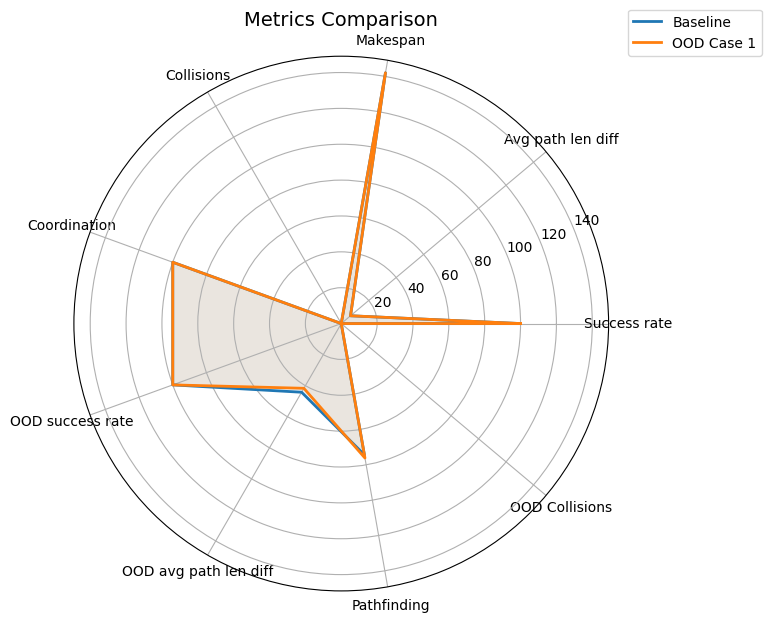

In [68]:
# create_metrics(agent_list,agent_removed_list,G,G_modified)
create_metrics(agent_list, agent_removed_list_metrics, G, G_modified_list, labels=None)


In [35]:
G=getGraphFromJson("validation-mazes-seed-000/9.json")
print(G.number_of_nodes())

305


In [49]:

def wrapped_main_function():
    return main_function("validation-mazes-seed-000/9.json",G,"berlin")

monitor_result = monitor_ram_and_gpu(wrapped_main_function)


agent_list, model = monitor_result["result"]
print(f"Peak RAM usage: {monitor_result['peak_ram']:.2f} MiB")
print(f"Peak GPU usage: {monitor_result['peak_gpu']:.2f} MiB")



[69, 70, 71, 72, 73, 74, 75, 76, 77]
[11, 28, 43]
[15, 14, 13, 30, 45, 61, 76, 75, 74, 73, 72, 71, 70, 69, 68, 85, 99, 114, 124, 123, 122, 113, 98, 97, 96, 83, 82]
[131, 117, 108, 91, 78, 62]
[302, 281, 271, 251, 241, 240, 239, 224, 212, 196, 185, 184, 183, 182, 181, 170, 155, 142, 128, 116, 104, 90, 74, 73, 72, 60, 59]
[60, 59, 58, 70, 86, 100, 115, 125, 140, 152, 153, 168, 179]
77
43
82
62
59
179


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

0 [69, 70, 71, 72, 73, 74, 75, 74, 73, 73, 74, 74, 75, 76, 77]
1 [11, 28, 43]
2 [15, 14, 31, 30, 45, 61, 76, 75, 74, 75, 75, 76, 61, 45, 61, 76, 75, 74, 73, 72, 71, 70, 69, 68, 85, 99, 114, 124, 123, 122, 113, 98, 97, 96, 95, 82]
3 [131, 117, 108, 91, 78, 62]
4 [302, 281, 271, 251, 241, 240, 239, 224, 212, 196, 185, 184, 183, 182, 181, 170, 155, 142, 128, 116, 104, 90, 74, 73, 72, 60, 59]
5 [60, 59, 58, 70, 86, 100, 115, 125, 140, 152, 167, 178, 179]
Peak RAM usage: 4018.77 MiB
Peak GPU usage: 1571.62 MiB


In [ ]:
perc=[0.1,0.2]
agent_removed_list_metrics=[]
G_modified_list=[]
for remove_percentage in perc:

    def wrapped_eval_function():
        return main_eval_function("validation-mazes-seed-000/9.json",G,model,"berlin",remove_percentage)
    monitor_result = monitor_ram_and_gpu(wrapped_eval_function)

    print(f"Peak RAM usage: {monitor_result['peak_ram']:.2f} MiB")
    print(f"Peak GPU usage: {monitor_result['peak_gpu']:.2f} MiB")
    agent_removed_list,G_modified= monitor_result["result"]
    agent_removed_list_metrics.append(agent_removed_list)
    G_modified_list.append(G_modified)




agent: 0
[69, 70, 71, 72, 73, 74, 75, 76, 77]
[69, 68, 85, 99, 114, 124, 139, 151, 166, 177, 191, 203, 202, 201, 219, 229, 247, 257, 258, 259, 279, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 281, 271, 251, 252, 242, 243, 225, 216, 197, 189, 171, 163, 145, 135, 118, 112, 93, 80, 63, 51, 50, 49, 48, 47, 62, 78, 77]
agent: 1
[11, 28, 43]
[11, 28, 43]
agent: 2
[15, 14, 13, 30, 45, 61, 76, 75, 74, 73, 72, 71, 70, 69, 68, 85, 99, 114, 124, 123, 122, 113, 98, 97, 96, 83, 82]
[15, 32, 47, 62, 78, 91, 108, 107, 106, 105, 104, 90, 89, 73, 72, 60, 42, 27, 10, 9, 8, 7, 6, 5, 4, 3, 2, 21, 36, 35, 53, 65, 82]
agent: 3
[131, 117, 108, 91, 78, 62]
[131, 132, 133, 134, 135, 118, 112, 93, 80, 63, 51, 50, 49, 48, 47, 62]
agent: 4
[302, 281, 271, 251, 241, 240, 239, 224, 212, 196, 185, 184, 183, 182, 181, 170, 155, 142, 128, 116, 104, 90, 74, 73, 72, 60, 59]
[302, 281, 271, 251, 250, 240, 239, 238, 237, 236, 235, 222, 209, 193, 181, 170, 155, 142, 128, 116, 104, 90, 89, 73, 72, 60, 5

100%|██████████| 1/1 [00:04<00:00,  4.46s/it]

0 [69, 68, 85, 99, 114, 124, 139, 151, 166, 177, 191, 203, 204, 205, 220, 232, 248, 261, 260, 259, 279, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 283, 273, 253, 243, 225, 216, 197, 189, 171, 163, 145, 135, 118, 112, 93, 80, 63, 51, 50, 49, 48, 47, 32, 47, 46, 45, 61, 76, 77]
1 [11, 28, 43]
2 [15, 32, 47, 62, 78, 91, 108, 107, 106, 105, 104, 90, 89, 73, 72, 71, 59, 58, 40, 39, 24, 7, 6, 5, 4, 3, 2, 21, 36, 35, 53, 65, 82]
3 [131, 132, 133, 134, 135, 118, 112, 93, 80, 63, 51, 50, 49, 48, 47, 62]
4 [302, 281, 271, 270, 269, 249, 239, 238, 237, 236, 235, 222, 209, 193, 181, 170, 155, 142, 128, 116, 104, 90, 89, 73, 72, 71, 59]
5 [60, 59, 71, 70, 69, 68, 85, 99, 114, 124, 139, 151, 166, 177, 191, 203, 204, 205, 220, 232, 248, 261, 260, 259, 279, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 281, 271, 251, 250, 249, 239, 238, 237, 236, 235, 222, 209, 193, 181, 170, 155, 142, 128, 127, 126, 141, 154, 169, 168, 179]
Peak RAM usage: 4018.88 Mi

agent: 0
[69, 70, 71, 72, 73, 74, 75, 76, 77]
[69, 70, 71, 72, 73, 74, 75, 76, 77]
agent: 1
[11, 28, 43]
[11, 28, 43]
agent: 2
[15, 14, 13, 30, 45, 61, 76, 75, 74, 73, 72, 71, 70, 69, 68, 85, 99, 114, 124, 123, 122, 113, 98, 97, 96, 83, 82]
[15, 32, 47, 48, 49, 50, 51, 63, 80, 93, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 88, 72, 60, 42, 41, 40, 25, 24, 7, 6, 5, 4, 22, 37, 55, 67, 84, 98, 97, 96, 83, 82]
agent: 3
[131, 117, 108, 91, 78, 62]
[131, 132, 133, 134, 135, 145, 163, 171, 189, 188, 187, 186, 185, 184, 183, 182, 194, 193, 181, 170, 155, 142, 128, 116, 104, 103, 89, 90, 74, 75, 76, 61, 45, 46, 47, 62]
agent: 4
[302, 281, 271, 251, 241, 240, 239, 224, 212, 196, 185, 184, 183, 182, 181, 170, 155, 142, 128, 116, 104, 90, 74, 73, 72, 60, 59]
[302, 301, 300, 299, 298, 297, 296, 280, 265, 266, 267, 268, 269, 249, 239, 238, 237, 236, 235, 222, 209, 193, 181, 170, 155, 142, 128, 116, 104, 103, 102, 88, 72, 71, 59]
agent: 5
[60, 59, 58, 70, 86, 100, 115, 125, 140, 152, 153, 

100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

0 [69, 70, 71, 72, 73, 74, 75, 76, 77]
1 [11, 28, 43]
2 [15, 32, 47, 48, 49, 50, 51, 63, 80, 93, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 88, 72, 60, 42, 42, 41, 40, 39, 24, 7, 6, 5, 4, 22, 37, 55, 67, 84, 98, 97, 96, 83, 82]
3 [131, 132, 133, 134, 135, 145, 163, 171, 189, 188, 187, 186, 185, 184, 183, 182, 194, 193, 181, 170, 155, 142, 128, 116, 104, 103, 89, 90, 74, 75, 76, 61, 45, 46, 47, 62]
4 [302, 301, 300, 299, 298, 297, 296, 280, 265, 266, 267, 268, 269, 249, 239, 238, 237, 236, 235, 222, 209, 193, 181, 170, 155, 142, 128, 116, 104, 103, 102, 88, 72, 71, 59]
5 [60, 72, 73, 74, 75, 76, 61, 45, 46, 47, 48, 49, 50, 51, 63, 80, 93, 112, 118, 135, 145, 163, 171, 189, 188, 187, 186, 185, 184, 183, 182, 194, 193, 181, 170, 155, 142, 128, 127, 126, 141, 154, 169, 180, 179]
Peak RAM usage: 4019.01 MiB
Peak GPU usage: 1571.62 MiB


Success rate: 1.0
Average path length difference: 18.9873417721519
Makespan: 35.0
Collisions: 0
Coordination: 1.0
agent: 0
agent: 1
agent: 2
agent: 3
agent: 4
agent: 5
ood_result: 1.0
ood_avg_path_len: 20.333333333333332
Pathfinding: 0.6423275089605734
OOD collisions: 0
agent: 0
agent: 1
agent: 2
agent: 3
agent: 4
agent: 5
ood_result: 1.0
ood_avg_path_len: 14.5
Pathfinding: 0.7939372718784483
OOD collisions: 0


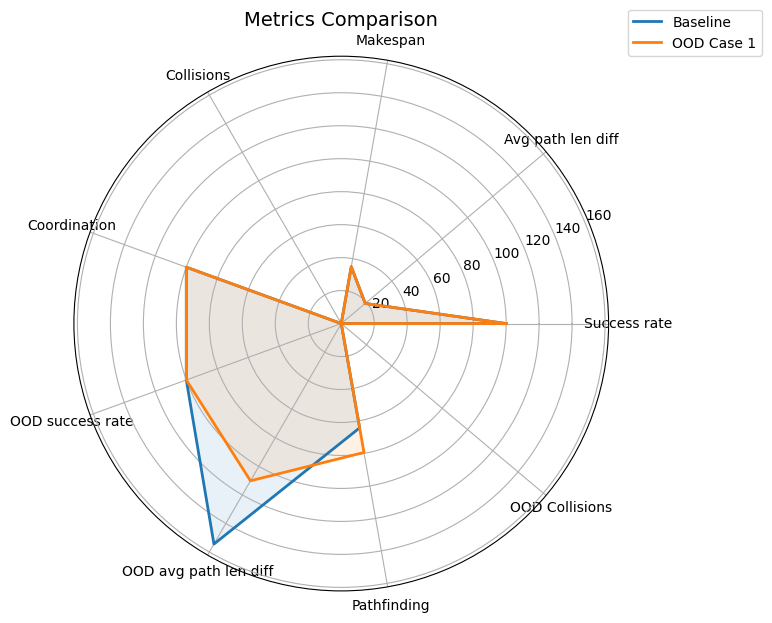

In [51]:
create_metrics(agent_list, agent_removed_list_metrics, G, G_modified_list, labels=None)


In [ ]:
# check letteratura altri approcci similix\

In [69]:
G=getGraphFromJson("Berlin_1_256_00/3.json")
print(G.number_of_nodes())

2837


In [71]:

def wrapped_main_function():
    return main_function("Berlin_1_256_00/3.json",G,"berlin")

monitor_result = monitor_ram_and_gpu(wrapped_main_function)


agent_list, model = monitor_result["result"]
print(f"Peak RAM usage: {monitor_result['peak_ram']:.2f} MiB")
print(f"Peak GPU usage: {monitor_result['peak_gpu']:.2f} MiB")



Graph is not strongly connected. Adding edges to make it strongly connected.
[2815, 2775, 2734, 2692, 2650, 2609, 2567, 2524, 2483, 2442, 2441, 2440, 2439, 2438, 2437, 2436]
[139, 75, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 2048, 2088, 2127, 2166, 2206, 2244, 2245, 2280, 2312, 2344, 2382, 2423, 2465, 2506, 2548, 2590, 2632]
[271, 207, 143, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64]
[2522, 2481, 2440, 2398, 2360, 2328, 2296, 2262, 2223, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198]
[1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 2007, 2045, 2046, 2086, 2125, 2164, 2203, 2204, 2242, 2277, 2309, 2340, 2373, 2411, 2412, 2413, 2414, 2415, 2374]
[1471, 1442, 1413, 1383, 1353, 1321, 1282, 1242, 1203, 1161, 1116, 1071, 1023, 977, 932, 883, 835, 783, 726, 725, 724, 723, 722, 721, 720, 719, 718, 717, 716]
2436
2632
64
2198
2374
716


100%|██████████| 1/1 [00:30<00:00, 30.27s/it]

0 [2815, 2775, 2734, 2692, 2650, 2609, 2608, 2566, 2523, 2522, 2481, 2440, 2439, 2438, 2437, 2436]
1 [139, 138, 74, 73, 72, 8, 7, 6, 5, 4, 3, 2, 1, 0, 2048, 2088, 2127, 2166, 2206, 2244, 2279, 2280, 2312, 2344, 2382, 2423, 2465, 2506, 2548, 2590, 2632]
2 [271, 270, 206, 142, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64]
3 [2522, 2523, 2524, 2483, 2442, 2443, 2401, 2363, 2331, 2299, 2265, 2226, 2186, 2147, 2148, 2148, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198]
4 [1945, 1984, 2022, 2062, 2101, 2102, 2141, 2142, 2143, 2144, 2183, 2184, 2185, 2186, 2187, 2227, 2228, 2229, 2230, 2231, 2232, 2231, 2191, 2192, 2193, 2194, 2195, 2196, 2234, 2235, 2236, 2237, 2272, 2304, 2305, 2336, 2369, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2374]
5 [1471, 1442, 1441, 1440, 1411, 1381, 1380, 1350, 1349, 1317, 1278, 1238, 1199, 1157, 1112, 1111, 1066, 1018, 972, 927, 878, 877, 829, 777, 776, 775, 774, 773, 716]
Peak RAM usage: 4258.91 MiB
Peak GPU usage

In [72]:
perc=[0.1,0.2]
agent_removed_list_metrics=[]
G_modified_list=[]
for remove_percentage in perc:

    def wrapped_eval_function():
        return main_eval_function("Berlin_1_256_00/0.json",G,model,"berlin",remove_percentage)
    monitor_result = monitor_ram_and_gpu(wrapped_eval_function)

    print(f"Peak RAM usage: {monitor_result['peak_ram']:.2f} MiB")
    print(f"Peak GPU usage: {monitor_result['peak_gpu']:.2f} MiB")
    agent_removed_list,G_modified= monitor_result["result"]
    agent_removed_list_metrics.append(agent_removed_list)
    G_modified_list.append(G_modified)



agent: 0
[1453, 1452, 1451, 1479, 1509, 1541, 1575, 1615, 1657, 1698, 1740, 1783, 1828, 1827, 1826, 1825, 1874, 1873, 1872, 1871, 1870, 1869, 1824, 1782, 1739, 1738, 1697, 1655, 1613, 1573, 1539, 1538, 1537, 1536, 1535, 1534, 1533]
[1453, 1481, 1480, 1510, 1542, 1576, 1616, 1658, 1699, 1741, 1740, 1783, 1828, 1827, 1826, 1825, 1874, 1873, 1872, 1871, 1870, 1869, 1824, 1782, 1739, 1738, 1697, 1655, 1613, 1573, 1572, 1571, 1570, 1569, 1535, 1534, 1533]
agent: 1
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 102, 166, 230, 294, 358, 422, 486, 550, 614, 674, 731]
[2, 3, 4, 5, 6, 7, 8, 9, 73, 74, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 225, 226, 227, 228, 229, 293, 357, 421, 485, 486, 550, 614, 674, 731]
agent: 2
[889, 840, 788, 732, 675, 615, 614, 613, 612, 611, 610, 609, 608, 607, 606, 605, 604, 603, 602, 601, 600, 59

100%|██████████| 1/1 [00:46<00:00, 46.11s/it]

0 [1453, 1481, 1480, 1510, 1542, 1576, 1616, 1658, 1699, 1741, 1740, 1783, 1828, 1877, 1876, 1875, 1874, 1873, 1872, 1914, 1913, 1912, 1911, 1910, 1909, 1908, 1907, 1865, 1866, 1821, 1820, 1778, 1735, 1694, 1693, 1651, 1609, 1608, 1607, 1567, 1533]
1 [2, 3, 4, 68, 132, 133, 134, 198, 262, 326, 390, 391, 455, 456, 457, 458, 459, 460, 461, 462, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 606, 607, 608, 609, 610, 611, 612, 613, 673, 674, 731]
2 [889, 888, 839, 787, 731, 674, 614, 613, 612, 611, 610, 609, 608, 607, 606, 670, 669, 668, 604, 603, 602, 666, 726, 725, 724, 723, 722, 721, 720, 719, 718, 717, 716, 773, 772, 771, 827, 826, 825, 876, 875, 924, 970, 1015, 1063, 1108, 1154, 1196, 1236, 1275, 1314, 1315, 1347, 1377, 1406, 1436, 1465, 1494, 1495, 1527, 1560, 1561, 1601, 1644, 1686, 1727, 1769, 1811, 1812, 1857]
3 [856, 905, 952, 997, 1045, 1044, 1091, 1137, 1182, 1181, 1180, 1179, 1178, 1220, 1219, 1218, 1257, 1297, 1296, 1334, 1367, 1397, 1427

agent: 0
[1453, 1452, 1451, 1479, 1509, 1541, 1575, 1615, 1657, 1698, 1740, 1783, 1828, 1827, 1826, 1825, 1874, 1873, 1872, 1871, 1870, 1869, 1824, 1782, 1739, 1738, 1697, 1655, 1613, 1573, 1539, 1538, 1537, 1536, 1535, 1534, 1533]
[1453, 1481, 1480, 1510, 1542, 1576, 1616, 1658, 1699, 1741, 1740, 1783, 1828, 1827, 1876, 1875, 1874, 1873, 1872, 1871, 1870, 1869, 1824, 1782, 1739, 1738, 1697, 1655, 1613, 1573, 1572, 1571, 1570, 1569, 1568, 1534, 1533]
agent: 1
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 102, 166, 230, 294, 358, 422, 486, 550, 614, 674, 731]
[2, 66, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 288, 289, 290, 291, 292, 293, 357, 421, 422, 486, 550, 614, 674, 731]
agent: 2
[889, 840, 788, 732, 675, 615, 614, 613, 612, 611, 610, 609, 608, 607, 606, 605, 604, 603, 60

100%|██████████| 1/1 [00:45<00:00, 45.17s/it]

0 [1453, 1481, 1511, 1510, 1542, 1576, 1616, 1658, 1699, 1741, 1740, 1783, 1828, 1827, 1876, 1875, 1874, 1873, 1872, 1871, 1870, 1869, 1824, 1782, 1739, 1738, 1737, 1736, 1735, 1734, 1693, 1692, 1691, 1649, 1607, 1567, 1533]
1 [2, 66, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 209, 273, 274, 338, 339, 340, 404, 405, 406, 470, 471, 472, 536, 537, 538, 539, 540, 541, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 674, 731]
2 [889, 888, 887, 838, 786, 730, 729, 672, 671, 611, 547, 546, 545, 544, 543, 542, 541, 605, 604, 603, 602, 601, 600, 599, 663, 662, 661, 721, 720, 719, 718, 717, 774, 773, 772, 771, 770, 769, 825, 876, 925, 971, 1016, 1064, 1109, 1108, 1154, 1196, 1236, 1275, 1274, 1313, 1345, 1375, 1404, 1434, 1435, 1464, 1493, 1494, 1526, 1559, 1599, 1642, 1684, 1725, 1767, 1809, 1854, 1855, 1856, 1857]
3 [856, 855, 854, 903, 902, 949, 994, 1042, 1089, 1088, 1087, 1133, 1178, 1177, 1219, 1218, 1217, 1256, 1296, 1295, 1294, 1293, 1331, 1364, 13

Success rate: 1.0
Average path length difference: 4.4585987261146505
Makespan: 46.0
Collisions: 0
Coordination: 1.0


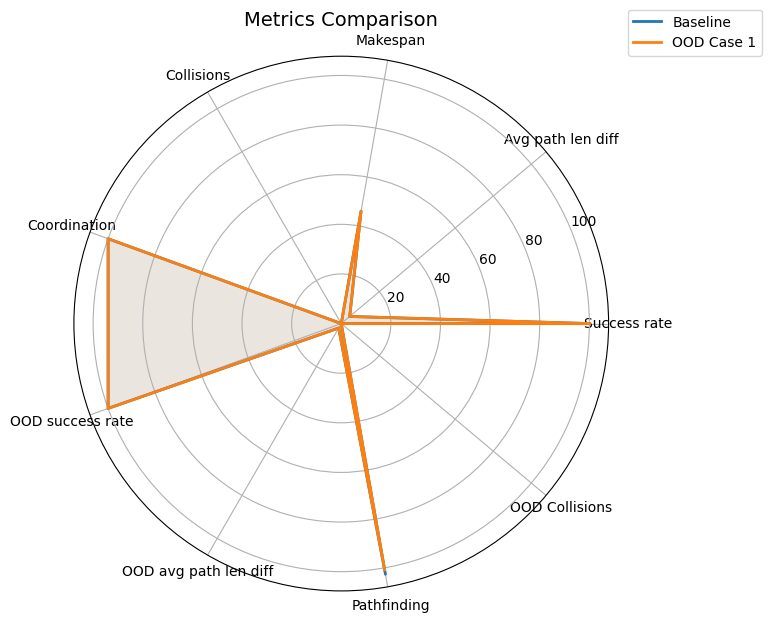

In [73]:
create_metrics(agent_list, agent_removed_list_metrics, G, G_modified_list, labels=None)
